<a href="https://colab.research.google.com/github/changsin/DL/blob/main/text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Detection Using OpenCV EAST

https://github.com/ZER-0-NE/EAST-Detector-for-text-detection-using-OpenCV


In [3]:
from PIL import Image, ImageDraw, ImageFont
 
img = Image.new('RGB', (100, 100), color = (255, 255, 255))
 
fnt = ImageFont.truetype('/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', 15)
d = ImageDraw.Draw(img)
d.text((10,10), "Hello world", font=fnt, fill=(0, 0, 0))
 
img.save('pil_text_font.jpg')

In [4]:
IMAGE_SIZE = 300

def create_text_image(text, filename, fontfile, font_size, start_x, start_y):
  img = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color = (255, 255, 255))
  fnt = ImageFont.truetype(fontfile, font_size)
  d = ImageDraw.Draw(img)
  d.text((start_x, start_y), "Hello world", font=fnt, fill=(0, 0, 0))
  img.save('pil_text_font.jpg')


In [13]:

path = '/usr/share/fonts/truetype/liberation/'
paths = (path + '*.ttf')

print(paths)
for file in paths:
  print(file)

  # image = cv2.imread(file)

/usr/share/fonts/truetype/liberation/*.ttf
/
u
s
r
/
s
h
a
r
e
/
f
o
n
t
s
/
t
r
u
e
t
y
p
e
/
l
i
b
e
r
a
t
i
o
n
/
*
.
t
t
f


In [122]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!wget https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb

--2021-07-26 08:11:20--  https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96662756 (92M) [application/octet-stream]
Saving to: ‘frozen_east_text_detection.pb’

frozen_east_text_de 100%[===================>]  92.18M   197MB/s    in 0.5s    

2021-07-26 08:11:24 (197 MB/s) - ‘frozen_east_text_detection.pb’ saved [96662756/96662756]



In [163]:
DATA_ROOT = "./drive/MyDrive/data/DataCentric/"
CLASS_NAMES = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
IMAGE_SIZE = 32 * 40

In [6]:
def glob_files(path):
    search_string = os.path.join(path,'*')
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [ ]:
def load_images(path):
  paths = (path)

  X_raw = []
  for file in paths:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))

    X_raw.append(np.array(image))

  return np.array(X_raw)

X_train_raw = load_images(DATA_ROOT + 'train/')

In [257]:
from pathlib import Path
from glob import glob
import os

# official convert_images method
def convert_images(input_folder, output_folder):
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    input_files = glob(os.path.join(input_folder, "*.png"))
    for f in input_files:
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        # quantize
        image = (image // 43) * 43
        image[image > 43] = 255
        cv2.imwrite(os.path.join(output_folder, os.path.basename(f)), image)

In [233]:
def load_image(filename):
  image = cv2.imread(filename)
  # image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  return image

# image = load_image('/content/P1300381.JPG')
# # image = load_image('/content/P1300382.JPG')


# orig = image.copy()
# (H, W) = image.shape[:2]

# # set the new width and height and then determine the ratio in change
# # for both the width and height
# # (newW, newH) = (W, H)
# # rW = W / float(newW)
# # rH = H / float(newH)

# # resize the image and grab the new image dimensions
# # image = cv2.resize(image, (newW, newH))
# (H, W) = image.shape[:2]

In [99]:
image.shape

(2400, 1800, 3)

In [106]:
# must be multiples of 32
# https://stackoverflow.com/questions/55963892/error-with-net-forward-in-opencv-east-text-detector-in-pycharm
IMAGE_SIZE = 320 * 3

W = IMAGE_SIZE
H = IMAGE_SIZE

image = cv2.resize(image, (W, H))

In [139]:
image.shape

(232, 232, 3)

In [105]:
image = load_image('/content/P1300390.JPG')

In [151]:
import cv2
import time

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
EAST_MODEL = "frozen_east_text_detection.pb"

def get_text_box_predictions(image):
  # load the pre-trained EAST text detector
  print("[INFO] loading EAST text detector...")
  net = cv2.dnn.readNet(EAST_MODEL)
  # construct a blob from the image and then perform a forward pass of
  # the model to obtain the two output layer sets
  # blob = cv2.dnn.blobFromImage(cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)), 1.0,
  #                              (IMAGE_SIZE, IMAGE_SIZE), (104.0, 177.0, 123.0))
  blob = cv2.dnn.blobFromImage(image, 1.0, (IMAGE_SIZE, IMAGE_SIZE),(123.68, 116.78, 103.94), swapRB=False, crop=False)
  start = time.time()
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  end = time.time()
  # show timing information on text prediction
  print("[INFO] text detection took {:.6f} seconds".format(end - start))

  return scores, geometry

In [243]:
import numpy as np
import matplotlib.pyplot as plt

from imutils.object_detection import non_max_suppression

def get_text_box_image(image, scores, geometry, confidence_threshold=.8):
  # grab the number of rows and columns from the scores volume, then
  # initialize our set of bounding box rectangles and corresponding
  # confidence scores
  (numRows, numCols) = scores.shape[2:4]
  rects = []
  confidences = []

  # # set the new width and height and then determine the ratio in change
  # # for both the width and height
  
  (newW, newH) = (IMAGE_SIZE, IMAGE_SIZE)
  W = IMAGE_SIZE
  H = IMAGE_SIZE
  # rW = W / float(newW)
  # rH = H / float(newH)

  orig = image.copy()

  # loop over the number of rows
  for y in range(0, numRows):
      # extract the scores (probabilities), followed by the geometrical
      # data used to derive potential bounding box coordinates that
      # surround text
      scoresData = scores[0, 0, y]
      xData0 = geometry[0, 0, y]
      xData1 = geometry[0, 1, y]
      xData2 = geometry[0, 2, y]
      xData3 = geometry[0, 3, y]
      anglesData = geometry[0, 4, y]

      # loop over the number of columns
      for x in range(0, numCols):

        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < confidence_threshold:
            continue

        # print("confidence: ", scoresData[x])

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

  # apply non-maxima suppression to suppress weak, overlapping bounding
  # boxes
  boxes = non_max_suppression(np.array(rects), probs=confidences)

  print(boxes)

  # loop over the bounding boxes
  for (startX, startY, endX, endY) in boxes:
      # # scale the bounding box coordinates based on the respective
      # # ratios
      # startX = int(startX * rW)
      # startY = int(startY * rH)
      # endX = int(endX * rW)
      # endY = int(endY * rH)

      # draw the bounding box on the image
      # cv2.rectangle(orig, (startX, startY), (endX, endY), (255, 0, 0), 1)
      orig = orig[startY:endY, startX:endX]

  return orig

In [259]:

def save_text_box_images(input_folder, output_folder):
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    input_files = glob(os.path.join(input_folder, "*.png"))
    for f in input_files:
        # image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(f)
        tb_image = to_text_box_image(image)

        resized = cv2.resize(tb_image, (IMAGE_SIZE*5, IMAGE_SIZE*5),
                             interpolation = cv2.INTER_AREA)
                     
        cv2.imwrite(os.path.join(output_folder, os.path.basename(f)), resized)

        # im = Image.fromarray(tb_image)
        # im = im.resize((IMAGE_SIZE*5, IMAGE_SIZE*5))
        # im.save("your_file.jpg")



        # quantize
        # image = (image // 43) * 43
        # image[image > 43] = 255
        # cv2.imwrite(os.path.join(output_folder, os.path.basename(f)), image)

In [260]:
[ save_text_box_images(DATA_ROOT + 'label_book/' + f, DATA_ROOT + 'label_book_t/' + f) for f in CLASS_NAMES]

[INFO] loading EAST text detector...
[INFO] text detection took 0.130897 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.116022 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.116355 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.129295 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.116560 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.116278 seconds
[[11  3 31 18]]
[INFO] loading EAST text detector...
[INFO] text detection took 0.122094 seconds
[[ 4  6 24 22]]
[INFO] loading EAST text detector...
[INFO] text detection took 0.116629 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.119645 seconds
[]
[INFO] loading EAST text detector...
[INFO] text detection took 0.118908 seconds
[[10  7 28 23]]
[INFO] loading EAST text detector...
[INFO] text detection took 0.114633 seconds
[[ 3  4 19 18]]
[INFO] loading EAST text

error: ignored

In [248]:
from PIL import Image

DATA_ROOT = "./drive/MyDrive/data/DataCentric/"
CLASS_NAMES = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
IMAGE_SIZE = 32 * 1

def to_text_box_image(image):
  # image = load_image('/content/drive/MyDrive/data/DataCentric/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png')
  # image = load_image('/content/P1300390.JPG')

  scores, geometry = get_text_box_predictions(image)
  tb_image = get_text_box_image(image, scores, geometry, confidence_threshold=0.1)

  return tb_image

im = cv2.imread("your_file.jpg")
# im = unsharp_mask(im)

# im = (im // 43) * 43
# im[im > 43] = 255
# cv2.imwrite(os.path.join(output_folder, os.path.basename(f)), image)



# im.shape

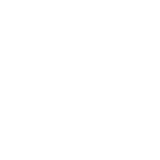

In [246]:
cv2_imshow(im)

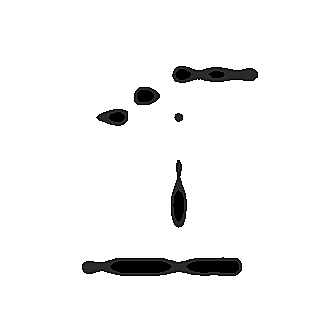

In [245]:
cv2_imshow(sharpened)

In [210]:
sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
# kernel = 1/3 * kernel

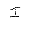

In [224]:
cv2_imshow(image)

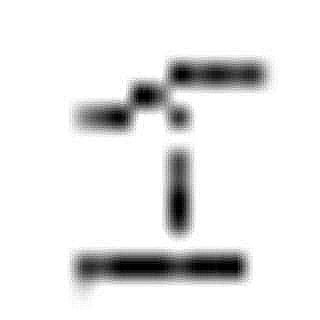

In [211]:
sharped_img = cv2.filter2D(im, -1, kernel)
# sharped_img = cv2.filter2D(sharped_img, -1, sharpen_filter)
cv2_imshow(sharped_img)

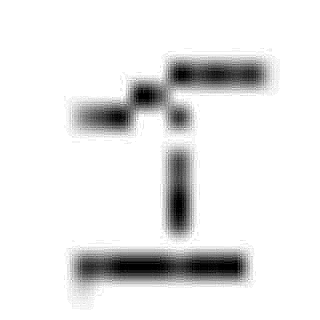

In [196]:
cv2_imshow(sharpened)

In [190]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

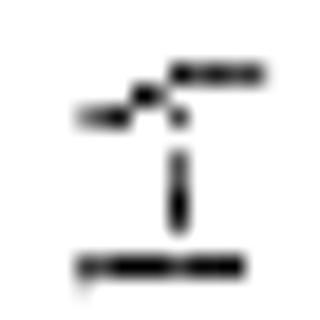

In [187]:
im = cv2.imread("your_file.jpg")
cv2_imshow(im)

In [138]:
image.shape

(232, 232, 3)

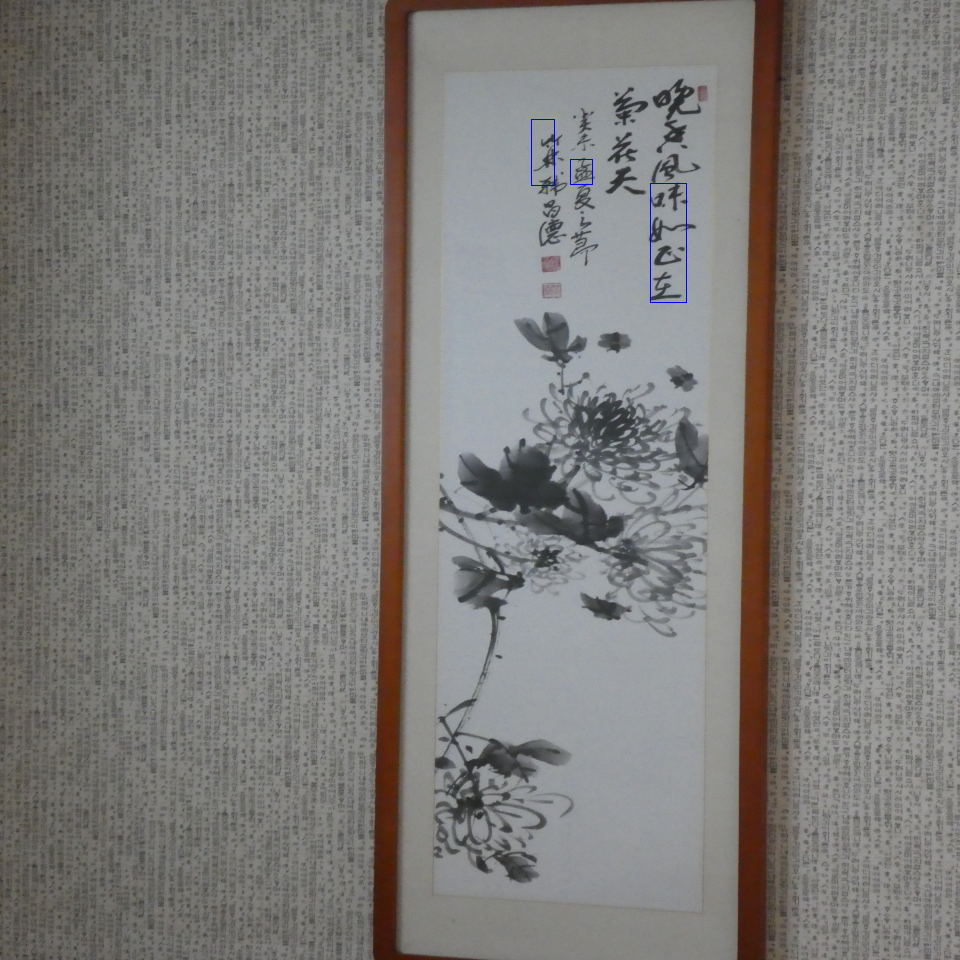

In [119]:
image_pred = get_text_box_image(image, scores, geometry)

cv2_imshow(image_pred)

In [77]:
orig.shape

(320, 320, 3)

In [72]:
image.shape

(320, 320, 3)

In [73]:
startX

196

In [95]:
new_img = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

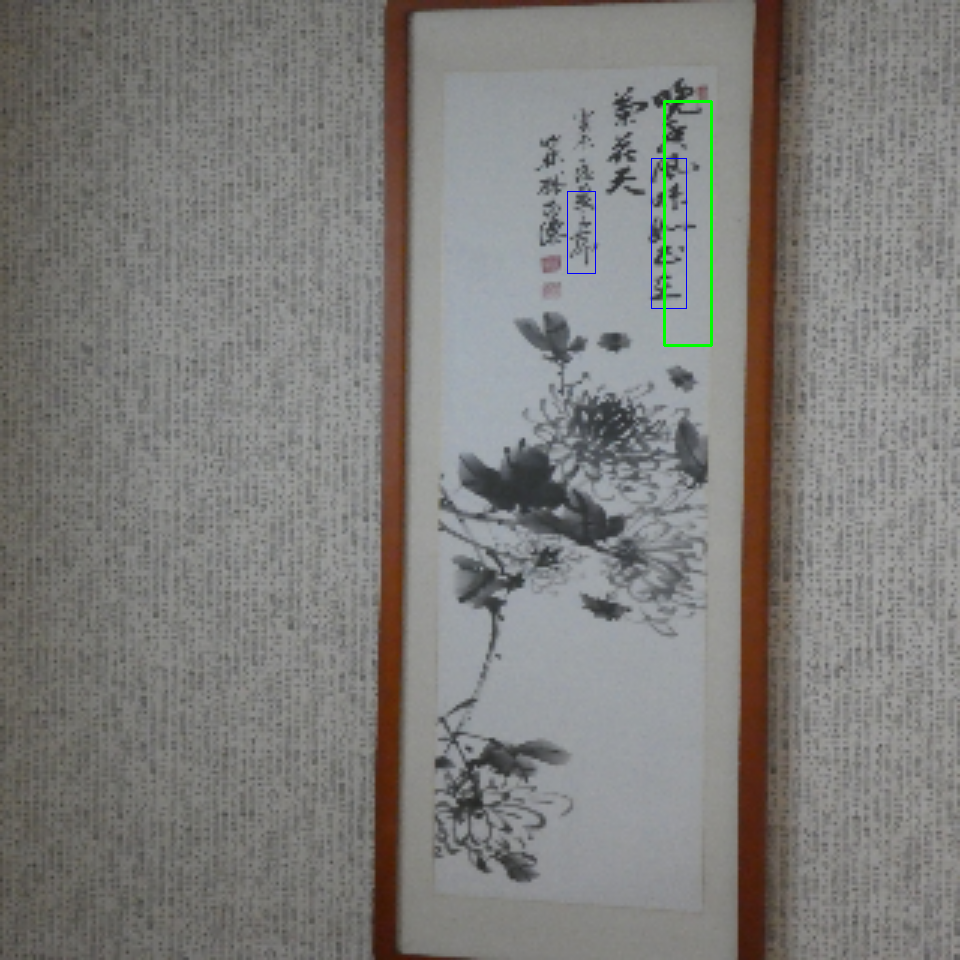

In [97]:
from google.colab.patches import cv2_imshow

cv2_imshow(new_img)